# CS:GO Economy Simulation


$$ \text{force_rate} = \frac{\text{Cost of Vest}}{\text{Starting Money}} $$ 

$$ \text{t_win_lean} = \frac{\text{CT Even Buy}}{\text{T Even Buy}} $$

$$ \text{t_plant_lean} = \frac{\text{CT Max Buy}}{\text{T Max Buy}} $$

---

$$ \text{ct_odds} = \frac{\text{CT money invested}}{\text{CT money invested} + \textit{t_win_lean}*\text{T money invest}} $$

$$ \text{plant_odds} = \frac{\text{CT money invested}}{\text{CT money invested} + \textit{t_plant_lean}*\text{T money invest}} $$

### Imports and Variable Initialization

In [1]:
import CS_EcoAnalyzer as cs

import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
market = {'AWP': 4750,
          'AK47': 2700,
          'M4A4': 3100,
          'M4A1': 2900,
          'Famas': 2050,
          'Galil': 1800,
          'Scout': 1700, 
          'Mag7': 1300, 
          'MP9': 1250,
          'Mac10': 1050,
          'Deagle': 700,
          'P250': 300,
          'Vesthelm': 1000,
          'Vest': 650,
          'Smoke': 300,
          'Flash': 200,
          'Molly': 400,
          'HE': 300,
          'Incendiary': 600,
          'DefuseKit': 400
         }
          

full_util_CT = market['Vesthelm'] + market['Smoke'] + market['Incendiary'] + market['Flash'] + market['HE'] + market['DefuseKit']
even_util_CT = market['Vest'] + market['Smoke'] + market['Incendiary'] + market['Flash'] + market['DefuseKit']
light_util_CT = market['Vest'] + market['Smoke'] +  market['Flash']*2 +  market['DefuseKit'] 

ct_max_buy = market['AWP']*2 + market['M4A4']*3 + full_util_CT*5 - (market['Vesthelm']-market['Vest'])*2
ct_even_buy =  market['AWP']*1 + market['M4A4']*4 + even_util_CT*5 - market['DefuseKit']*2
ct_min_buy = market['M4A1']*2 + market['Famas']*2 + market['MP9'] + light_util_CT*5  - market['DefuseKit']*3 + market['Incendiary']*3 

full_util_T = market['Vesthelm']+market['Smoke']+market['Molly']+market['Flash']*2
t_max_buy =  market['AWP']*1 + market['AK47']*4 + full_util_T*5
t_even_buy = market['AK47']*5 + full_util_T*5
t_min_buy = market['AK47']*2 + market['Galil']*2 + market['Deagle'] + full_util_T*4 - market['Molly']*2

t_win_lean = ct_even_buy/t_even_buy
t_plant_lean = ct_max_buy/t_min_buy

ct_buy_levels = [ct_max_buy/5, ct_even_buy/5, ct_min_buy/5]
t_buy_levels = [t_max_buy/5, t_even_buy/5, t_min_buy/5]

starting_money = 800
starting_loss = 1
force_percent = market['Vest']/starting_money
liverate_kill = (market['AWP']+market['AK47']+market['Vest']*2+market['DefuseKit']+market['Flash']*2)/ct_even_buy
liverate_obj= (market['AWP']+market['Vest']+market['DefuseKit']+market['Flash'])/ct_even_buy
liverate_save = (market['AWP']+market['M4A4']*3 + market['Vest']*4+full_util_CT)/ct_even_buy


eco_rules = {'starting_mny': starting_money,
                'starting_loss': starting_loss,
                'win_reward_kill': 3250,
                'win_reward_obj': 3500,
                'loss_reward': 1400,
                'loss_increment': 500,
                'kill_reward': 300,
                'plant_reward': 800,
                'max_mny': 16000,
                'max_loss': 5,
                'MR': 15,
                'market': market,
             # These values are calculated, but speculation
             # See Methodology in README for breakdown 
                'ct_bl': ct_buy_levels, 
                't_bl': t_buy_levels,
                't_win_lean': t_win_lean,
                't_plant_lean': t_plant_lean,
                'force_rate': force_percent,
                'win_LR_kill': liverate_kill,
                'win_LR_obj': liverate_obj,
                'win_LR_save':liverate_save,
             # NO IDEA about these values, pure guesswork
                'save_returnrate': 1/5
            }
            
starting_gamestate = {'ct_mny': eco_rules['starting_mny'],
                        'ct_loss':eco_rules['starting_loss'],
                        't_mny':eco_rules['starting_mny'],
                        't_loss':eco_rules['starting_loss'],
                        't_wins':0,
                        'rnds_played':0
                     }  

#### Simulating a single half and outputting the results of each round

In [3]:
importlib.reload(cs) #necessary for module debugging
n_of_1 = cs.half_simulator(eco_rules, starting_gamestate, 1)
(pd.DataFrame(n_of_1[0]))

,winner,event,CT_mnyinvest,CT_buyoption,T_mnyinvest,T_buyoption,gamestate
0,CT,bomb_plant_force,650.0,F,650.0,F,"{'ct_mny': 4094.0, 'ct_loss': 0, 't_mny': 3650..."
1,T,none,0.0,S,3460.0,B,"{'ct_mny': 5994.0, 'ct_loss': 1, 't_mny': 4959..."
2,T,bomb_plant,5420.0,B,4800.0,B,"{'ct_mny': 4058.0, 'ct_loss': 2, 't_mny': 5022..."
3,T,none,0.0,S,4800.0,B,"{'ct_mny': 6958.0, 'ct_loss': 3, 't_mny': 5464..."
4,T,none,6420.0,B,5210.0,B,"{'ct_mny': 3938.0, 'ct_loss': 4, 't_mny': 5640..."
5,T,none,0.0,S,5210.0,B,"{'ct_mny': 7838.0, 'ct_loss': 5, 't_mny': 5816..."
6,T,bomb_plant,6420.0,B,5210.0,B,"{'ct_mny': 6602.0, 'ct_loss': 5, 't_mny': 5560..."
7,T,none,6420.0,B,5210.0,B,"{'ct_mny': 4082.0, 'ct_loss': 5, 't_mny': 5736..."
8,T,none,0.0,S,5210.0,B,"{'ct_mny': 7982.0, 'ct_loss': 5, 't_mny': 5912..."
9,CT,none,6420.0,B,5210.0,B,"{'ct_mny': 7374.0, 'ct_loss': 4, 't_mny': 2802..."


# Large-Scale Simulation

#### n = 100000

plans to optimize this section to allow for more robust exploration (spending trends, pattern freqs, etc). I want to see what analysis I can perform on actual CS matches first.

In [4]:
n = 100000
simulation = cs.half_simulator(eco_rules, starting_gamestate, n)

In [5]:
#Arrays to track data
pistol_results = []
secondround_results = []
thirdround_results = []
half_results = []
round_results = []

# 2nd round Analysis
t_buyoption_2round = []
gs_tmny_2round = []
ct_buyoption_2round = []
gs_ctmny_2round = []



for i in range(n):
    pistol_results.append(simulation[i][0]['winner'] + " " + simulation[i][0]['event'])
    secondround_results.append(simulation[i][1]['winner'] + " " + simulation[i][1]['event'])
    t_buyoption_2round.append(simulation[i][1]['T_buyoption'])
    ct_buyoption_2round.append(simulation[i][1]['CT_buyoption'])
    gs_tmny_2round.append(simulation[i][1]['gamestate']['t_mny'])
    gs_ctmny_2round.append(simulation[i][1]['gamestate']['ct_mny'])
    thirdround_results.append(simulation[i][2]['winner'] + " " + simulation[i][2]['event'])
    half_results.append(simulation[i][-1]['gamestate']['t_wins'])
    
    
for j in range(eco_rules['MR']):
        round_results.append([simulation[i][j]['winner'] for i in range(n)])

###  Total rounds won distribution

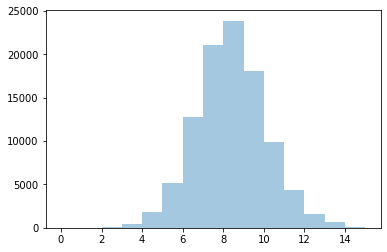

In [6]:
sns.distplot(half_results, bins=eco_rules['MR'], kde=False)

In [7]:
stats.describe(half_results)

DescribeResult(nobs=100000, minmax=(0, 15), mean=7.89155, variance=3.066779265292652, skewness=0.13492746276549608, kurtosis=0.3688889108409996)

### Round won distribution per round

- Framed from CT side in table

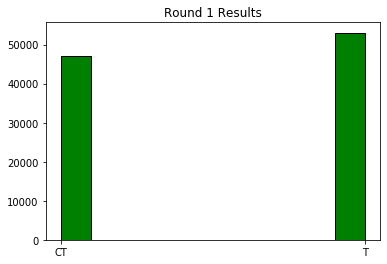

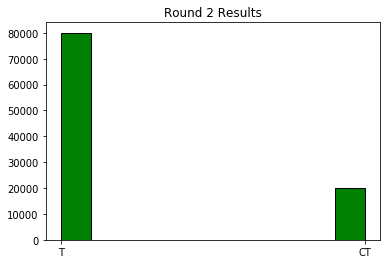

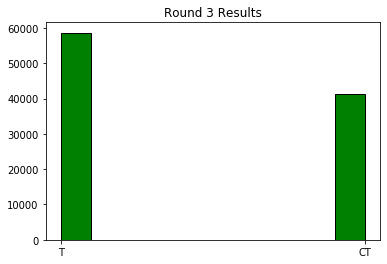

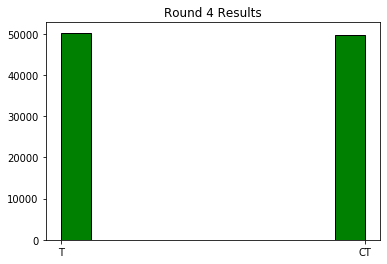

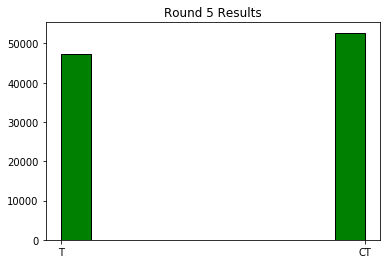

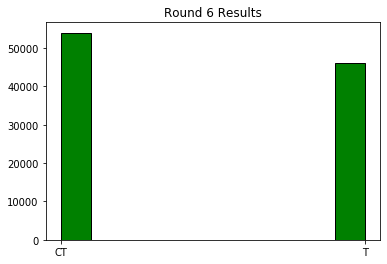

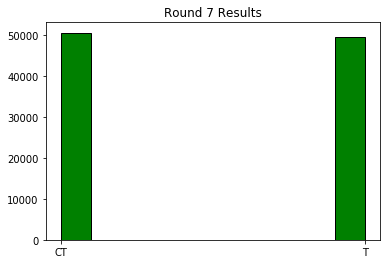

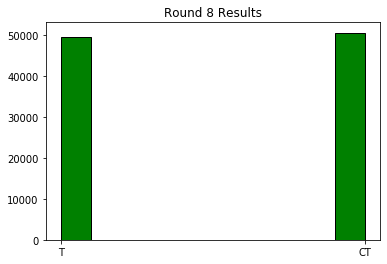

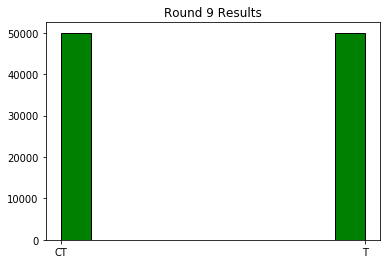

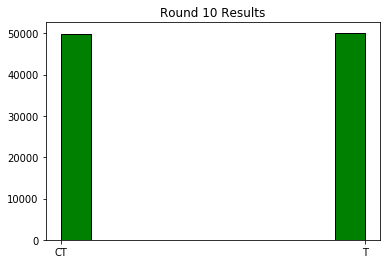

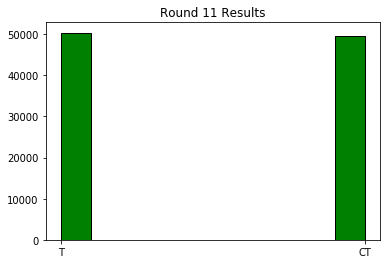

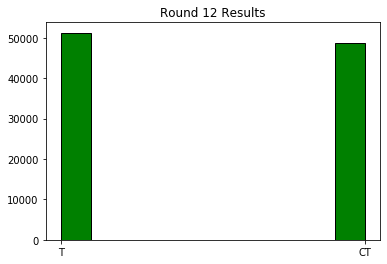

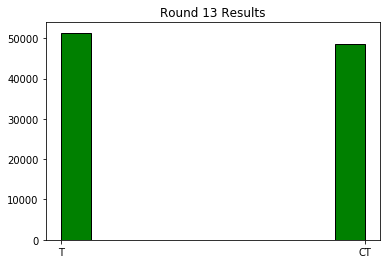

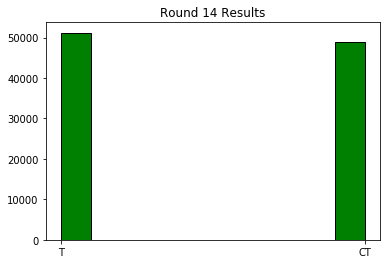

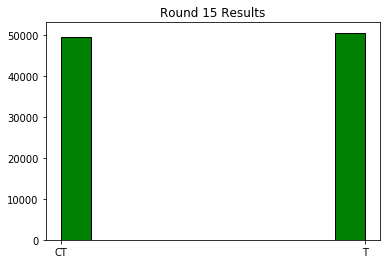

In [8]:
for k in range(eco_rules['MR']):
    plt.hist(round_results[k], color = 'green', edgecolor = 'black', stacked=False)
    tit = "Round "+str(k+1)+" Results"
    plt.title(tit)
    plt.show()


In [9]:
ct_win_percent = []
for i in range(eco_rules['MR']):
    ct_win_percent.append([i+1, sum([1 for x in round_results[i] if x=='CT'])])
    
ctw_df = pd.DataFrame(ct_win_percent, columns=['Round', 'CT Win %']).to_string(index=False)
print(ctw_df)

 Round  CT Win %
     1     46960
     2     19934
     3     41361
     4     49724
     5     52734
     6     54000
     7     50489
     8     50576
     9     50007
    10     49852
    11     49630
    12     48723
    13     48624
    14     48792
    15     49439


### Event Analysis for first 3 rounds

(array([34954.,     0.,     0., 31079.,     0.,     0., 21961.,     0.,
            0., 12006.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

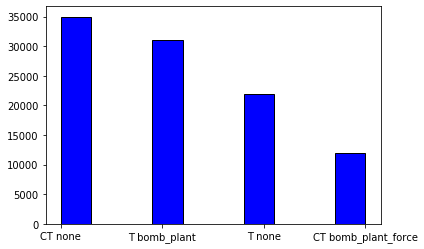

In [10]:
plt.hist(pistol_results, color = 'blue', edgecolor = 'black')

(array([1.3698e+04, 0.0000e+00, 6.6368e+04, 0.0000e+00, 0.0000e+00,
        1.5538e+04, 0.0000e+00, 4.3910e+03, 0.0000e+00, 5.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

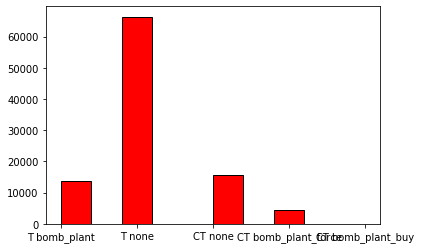

In [11]:
plt.hist(secondround_results, color = 'red', edgecolor = 'black')

(array([30681.,     0.,     0., 15487.,     0.,     0., 27958.,     0.,
            0., 25874.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

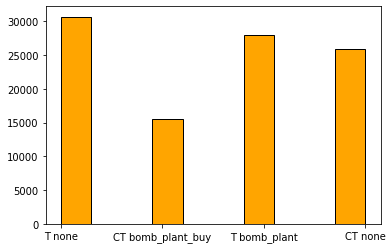

In [12]:
plt.hist(thirdround_results, color = 'orange', edgecolor = 'black')

### Deeper Analysis of extreme CT loss on second round phenomena

(array([34954.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65046.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

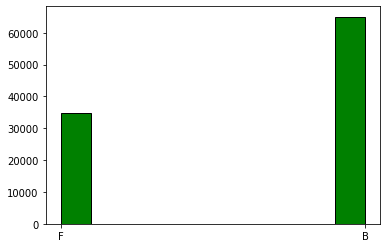

In [13]:
plt.hist(t_buyoption_2round, color = 'green', edgecolor = 'black')

(array([34954.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65046.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

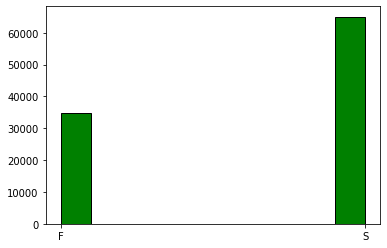

In [14]:
plt.hist(ct_buyoption_2round, color = 'green', edgecolor = 'black')

(array([4.0000e+00, 0.0000e+00, 3.0000e+00, 1.5536e+04, 0.0000e+00,
        0.0000e+00, 4.3910e+03, 1.5034e+04, 1.2002e+04, 5.3030e+04]),
 array([2569. , 2852.4, 3135.8, 3419.2, 3702.6, 3986. , 4269.4, 4552.8,
        4836.2, 5119.6, 5403. ]),
 <a list of 10 Patch objects>)

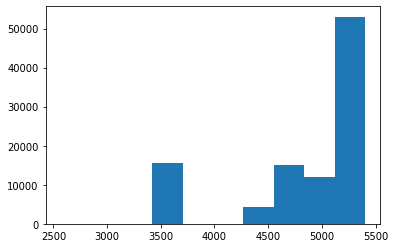

In [15]:
plt.hist(gs_tmny_2round)

(array([1.5032e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.2953e+04, 1.2007e+04, 5.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([2637. , 3137.7, 3638.4, 4139.1, 4639.8, 5140.5, 5641.2, 6141.9,
        6642.6, 7143.3, 7644. ]),
 <a list of 10 Patch objects>)

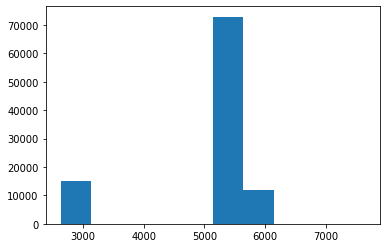

In [16]:
plt.hist(gs_ctmny_2round)